# **Disaster Tweets**

---
---
# **1.  Brief description of the problem and data**

---
### Overview

In this project, we use recurrent deep learning models to examine a series of tweets and conduct a binary class classification task that aims to classify them into two categories:

* $0$ — tweets announcing a disaster
* $1$ — tweets *not* announcing a disaster

Models were evaluated by F1 score on the validation set. Accuracy scores were also included as secondary metric.

In [1]:
# -----------------------------
# Import libraries
# -----------------------------

# Silence Warnings
import warnings
warnings.filterwarnings("ignore")

# General libraries
import os
import numpy as np
import pandas as pd

from IPython.display import display, HTML

# Visualizations
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix
)

# Text Processing
import re
import spacy
import string

# TensorFlow
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
        Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D,
        MaxPooling1D, GlobalMaxPooling1D
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2


# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-12-06 22:41:13.918072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765060873.945932    9476 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765060873.953714    9476 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
# Set random_state for reproducibility
random_state = 86

<br>

---
---
# **2.  Exploratory Data Analysis (EDA)**

---
## Import and Load Data

Our raw data comes in two tabulated tabulated .csv files—one for the train data and one for the test data. Their sizes are:

* **Train Raw:** &ensp;
  $7613$ rows × $5$ columns
* **Test Raw:** &emsp;
  $3263$ rows × $4$ columns

The train data has 5 columns listed in the table below. The `target` column was not avialable in the test data because our goal was to classify these tweets with the appropriate target value.

| **Column** | **Meaning**                                   |
|------------|-----------------------------------------------|
| `id`       | ID number of tweet                            |
| `keyword`  | main keyword from tweet                       |
| `location` | location of tweet poster                      |
| `text`     | text from tweet                               |
| `target`   | $0$ = NOT a distaster; $1$ = Disaster |

Because we found several `NaN` values upon calling the `.head()` function to preview these datasets, we clearly have several null values to clean.

In [3]:
# -----------------------------
# Load files
# -----------------------------
train_raw = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_raw = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [4]:
# -----------------------------
# Initial look at data .info()
# -----------------------------
display(HTML(f"<strong>Train Raw Data</strong>"))
train_raw.info()

print("")

display(HTML(f"<strong>Test Raw Data</strong>"))
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [5]:
# -----------------------------
# View data .head()
# -----------------------------
display(HTML(f"<strong>Train Raw Data</strong>"))
print(f"Size:    {train_raw.shape[0]} rows × {train_raw.shape[1]} columns")
display(train_raw.head())

print("")

display(HTML(f"<strong>Test Raw Data</strong>"))
print(f"Size:    {test_raw.shape[0]} rows × {test_raw.shape[1]} columns")
display(test_raw.head())

Size:    7613 rows × 5 columns


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Size:    3263 rows × 4 columns


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


---
## Visualize Data

Before we begin the cleaning process, we plotted a bar chart and pie chart to show distribution of our raw training data. We did not do this for our test data because labels were not available.

Out of
${\color{ForestGreen}{n}}
    = {\color{ForestGreen}{7613}}$
tweets,
${\color{RoyalBlue}{4342}} \, ( {\color{RoyalBlue}{57 \%}} )$
were not announcing disasters, while
${\color{Crimson}{3271}} \,( {\color{Crimson}{43 \%}} )$
did. We plotted a pie chart and histogram to show this distribution and marked non-disaster tweets in blue and disaster tweets in red.

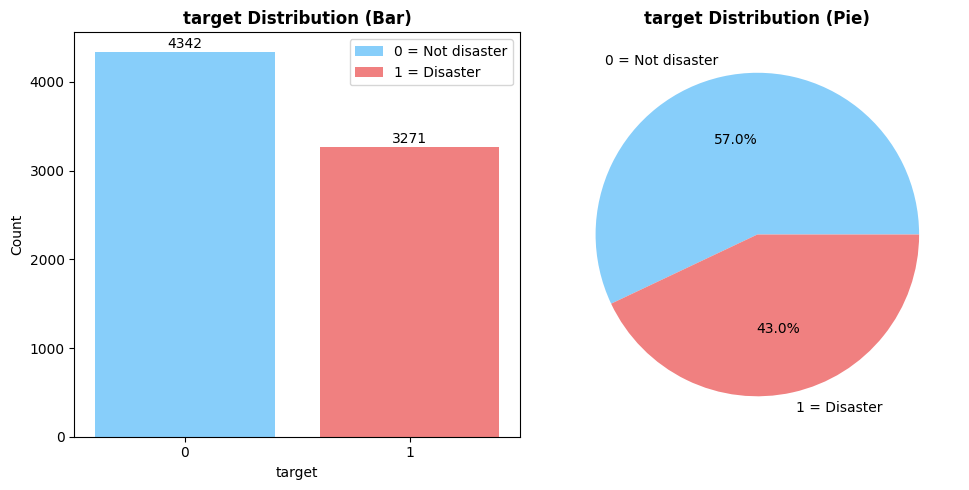

In [6]:
# -----------------------------
# Plot distribution of target labels in train_raw
# -----------------------------
display(HTML(f"<strong>Train Raw Data</strong>"))

train_labels = train_raw.columns[-1]
counts = train_raw[train_labels].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
legend_labels = ["0 = Not disaster", "1 = Disaster"]

# Bar chart
bars = axes[0].bar(counts.index.astype(str), counts.values,
                   color=["LightSkyBlue", "LightCoral"])
axes[0].set_title(f"{train_labels} Distribution (Bar)", weight="bold")
axes[0].set_xlabel(train_labels)
axes[0].set_ylabel("Count")
axes[0].legend(bars, legend_labels)
for bar in bars:
    height = bar.get_height()
    axes[0].annotate(
        f"{height}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 0.5),
        textcoords="offset points",
        ha="center",
        va="bottom",
    )

# Pie chart
axes[1].pie(counts.values, autopct="%1.1f%%",
            colors=["LightSkyBlue", "LightCoral"], labels=legend_labels)
axes[1].set_title(f"{train_labels} Distribution (Pie)", weight="bold")

plt.tight_layout()
plt.show()

---
## Data Preprocessing

Our data preprocessing pipeline consisted of the following steps:

* **Step 1:** Check for duplicates and nulls.
* **Step 2:** Drop the columns `keyword` and `location` with null values.
* **Step 3:** Clean text with regex.
* **Step 4:** Lemmatize cleaned text.

Our final data sizes were:

* **Train Raw:** &ensp;
  $7613$ rows × $3$ columns
* **Test Raw:** &emsp;
  $3263$ rows × $2$ columns

In [7]:
# ============================
# Step 1: Check dupes and nulls.
# ============================

# -----------------------------
# Check train_raw
# -----------------------------
display(HTML(f"<strong>Train Raw Data</strong>"))
print(f"Size:    {train_raw.shape[0]} rows × {train_raw.shape[1]} columns")
train_duplicates = train_raw.duplicated().sum()
print(f"Number of duplicates:    {train_duplicates}")
missing_values_df = (
    train_raw.isnull()
    .sum()
    .to_frame(name="missing_count")
)
print(missing_values_df)

# -----------------------------
# Check test_raw
# -----------------------------
display(HTML(f"<br><strong>Test Raw Data</strong>"))
print(f"Size:    {test_raw.shape[0]} rows × {test_raw.shape[1]} columns")
test_duplicates = test_raw.duplicated().sum()
print(f"Number of duplicates:    {test_duplicates}")
missing_values_df = (
    test_raw.isnull()
    .sum()
    .to_frame(name="missing_count")
)
print(missing_values_df)

keyword_null = test_raw["keyword"].isnull().sum()
keyword_non_null = len(test_raw) - keyword_null
location_null = test_raw["location"].isnull().sum()
location_non_null = len(test_raw) - location_null

Size:    7613 rows × 5 columns
Number of duplicates:    0
          missing_count
id                    0
keyword              61
location           2533
text                  0
target                0


Size:    3263 rows × 4 columns
Number of duplicates:    0
          missing_count
id                    0
keyword              26
location           1105
text                  0


In [8]:
# ============================
# Step 2: Drop cols w/ nulls.
# ============================

# -----------------------------
# Drop train_v1 nulls
# -----------------------------
display(HTML(f"<strong>Train v1</strong>"))
train_v1 = train_raw.copy().drop(columns=["keyword", "location"], axis=1)
print(f"Size:    {train_v1.shape[0]} rows × {train_v1.shape[1]} columns")
display(train_v1.info())

# -----------------------------
# Drop test_v1 nulls
# -----------------------------
display(HTML(f"<br><strong>Test v1</strong>"))
test_v1 = test_raw.copy().drop(columns=["keyword", "location"], axis=1)
print(f"Size:    {test_v1.shape[0]} rows × {test_v1.shape[1]} columns")
display(test_v1.info())

Size:    7613 rows × 3 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


None

Size:    3263 rows × 2 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB


None

In [9]:
# =============================
# Step 3. Clean text w/ regex
# =============================

# -----------------------------
# Helper function to clean text with regex
# -----------------------------
def clean_text(text):
    text = text.lower()  # lowercase text
    text = re.sub(r"\[.*?\]", " ", text)                      # Remove text in []
    text = re.sub(r"http\S+", " ", text)                      # Remove URLs
    text = re.sub(r"<.*?>+", " ", text)                       # Remove HTML tags
    text = re.sub(r"[%s]" % re.escape(string.punctuation),    # Remove punctuation
                  " ", text)
    text = re.sub(r"\n", " ", text)                           # Remove new lines
    text = re.sub(r"\w*\d\w*", " ", text)                     # Remove words w/ digits
    text = re.sub(r"\s+", " ", text)                          # Remove multiple spaces
    return text

# -----------------------------
# Clean train_v1
# -----------------------------
train_v2 = train_v1.copy()
train_v2["clean_text"] = train_v2["text"].apply(clean_text)
train_v2 = train_v2.drop("text", axis=1)
display(HTML(f"<strong>Train v2</strong>"))
print(f"Size:    {train_v2.shape[0]} rows × {train_v2.shape[1]} columns")
display(train_v2.head())

# -----------------------------
# Clean test_v1
# -----------------------------
test_v2 = test_v1.copy()
test_v2["clean_text"] = test_v2["text"].apply(clean_text)
test_v2  = test_v2.drop("text", axis=1)
display(HTML(f"<br><strong>Test v2</strong>"))
print(f"Size:    {test_v2.shape[0]} rows × {test_v2.shape[1]} columns")
display(test_v2.head())

Size:    7613 rows × 3 columns


,id,target,clean_text
0,1,1,our deeds are the reason of this earthquake ma...
1,4,1,forest fire near la ronge sask canada
2,5,1,all residents asked to shelter in place are be...
3,6,1,people receive wildfires evacuation orders in...
4,7,1,just got sent this photo from ruby alaska as s...


Size:    3263 rows × 2 columns


,id,clean_text
0,0,just happened a terrible car crash
1,2,heard about earthquake is different cities sta...
2,3,there is a forest fire at spot pond geese are ...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills in china and taiwan


In [10]:
# =============================
# Step 4. Lemmatize cleaned text.
# =============================

# -----------------------------
# Helper function to lemmatize text
# -----------------------------
def clean_text_lemma(doc):
    return " ".join(
        token.lemma_.lower()
        for token in doc
        if not token.is_stop
        and not token.is_punct
        and not token.is_space
        and not token.like_num
        and token.pos_ in {"NOUN", "VERB", "ADJ", "PROPN"}
    )

# ---------------------------------------
# Lemmatize train_v2
# ---------------------------------------
train_v3 = train_v2.copy().drop("clean_text", axis=1)
train_v3["clean_text_lemma"] = train_v2["clean_text"].apply(clean_text)
train_v3.loc[0, "clean_text_lemma"]
display(HTML(f"<strong>Train v3</strong>"))
print(f"Size:    {train_v3.shape[0]} rows × {train_v3.shape[1]} columns")
display(train_v3.head())

# ---------------------------------------
# Lemmatize test_v2
# ---------------------------------------
test_v3 = test_v2.copy().drop("clean_text", axis=1)
test_v3["clean_text_lemma"] = test_v2["clean_text"].apply(clean_text)
test_v3.loc[0, "clean_text_lemma"]
display(HTML(f"<br><strong>Test v3</strong>"))
print(f"Size:    {test_v3.shape[0]} rows × {test_v3.shape[1]} columns")
display(test_v3.head())

Size:    7613 rows × 3 columns


,id,target,clean_text_lemma
0,1,1,our deeds are the reason of this earthquake ma...
1,4,1,forest fire near la ronge sask canada
2,5,1,all residents asked to shelter in place are be...
3,6,1,people receive wildfires evacuation orders in...
4,7,1,just got sent this photo from ruby alaska as s...


Size:    3263 rows × 2 columns


,id,clean_text_lemma
0,0,just happened a terrible car crash
1,2,heard about earthquake is different cities sta...
2,3,there is a forest fire at spot pond geese are ...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills in china and taiwan


<br>

---
---
# **3.  Model Architecture**

---
## Define Parameters

Before we build our models, we set our initial hyperparameters. We set `max_words=10000` to set the vocabulary size for our analysis. We set `max_len=50` to set a maximum of
$50$
tokens per sequence (ie. tokens per tweet we analyze).

From here, we built our helper functions to generate our tonkenized data for the following subsets:

  * train + valid: both split from or `training_v3` data
  * test: unlabeled tweets for us to classify

From here, we developed two models:

  * Stacked LSTM
  * Hybrid Conv 1D + LSTM

We also set a class for `F1Score` since this will be the primary metric we use to evaluate our models.

In [11]:
# -------------------------
# Hyperparameters
# -------------------------
max_words = 10000
max_len   = 50 

In [12]:
# -----------------------------
# Train + Val Set
# -----------------------------
train_v3_texts = train_v3["clean_text_lemma"].values
train_v3_labels = train_v3["target"].values

# Train-Validation Split
X_train_texts, X_val_texts, y_train, y_val = train_test_split(
    train_v3_texts,
    train_v3_labels,
    test_size=0.2,
    random_state=86,
    shuffle=True,
    stratify=train_v3_labels
)

# Tokenize
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_texts)  # fit only on train!

# Convert texts to integer sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_val_seq   = tokenizer.texts_to_sequences(X_val_texts)

# Pad sequences to fixed length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_val_pad   = pad_sequences(X_val_seq, maxlen=max_len, padding="post")

# Final train + val sets
train_set = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train)).batch(32)
train_set = train_set.prefetch(tf.data.AUTOTUNE)
val_set = tf.data.Dataset.from_tensor_slices((X_val_pad, y_val)).batch(32)
val_set   = val_set.prefetch(tf.data.AUTOTUNE)

display(HTML(f"<strong>Train Set</strong>"))
display(HTML(f"&ensp; &ensp; <strong>X-train pad</strong>"))
print(f"  Size:    {X_train_pad.shape[0]} rows × {X_train_pad.shape[1]} columns")
display(HTML(f"&ensp; &ensp; <strong>y-train (distribution)</strong>"))
print(f"  0s:    {np.bincount(y_train)[0]}")
print(f"  1s:    {np.bincount(y_train)[1]}")

display(HTML(f"<br><strong>Val Set</strong>"))
display(HTML(f"&ensp; &ensp; <strong>    X-val pad</strong>"))
print(f"  Size:    {X_val_pad.shape[0]} rows × {X_val_pad.shape[1]} columns")
display(HTML(f"&ensp; &ensp; <strong>y-val (distribution)</strong>"))
print(f"  0s:    {np.bincount(y_val)[0]}")
print(f"  1s:    {np.bincount(y_val)[1]}")

2025-12-06 22:41:20.751551: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


  Size:    6090 rows × 50 columns


  0s:    3473
  1s:    2617


  Size:    1523 rows × 50 columns


  0s:    869
  1s:    654


In [13]:
# -----------------------------
# Test Set
# -----------------------------
test_v3_texts = test_v3["clean_text_lemma"].values
X_test_texts = test_v3_texts

# Convert texts to integer sequences
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

# Pad sequences to fixed length
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

# Final test sets
test_set = tf.data.Dataset.from_tensor_slices(X_test_pad).batch(32)

display(HTML(f"<strong>Test Set</strong>"))
display(HTML(f"&ensp; &ensp; <strong>X-test pad</strong>"))
print(f"  Size:    {X_test_pad.shape[0]} rows × {X_test_pad.shape[1]} columns")

  Size:    3263 rows × 50 columns


In [14]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * (p * r) / (p + r + 1e-7)

    def reset_states(self):        
        self.precision.reset_state()
        self.recall.reset_state()

---
## Model 1: Stacked LSTM

Our first model is a stacked recurrent long short-term memory (LSTM) neural network designed to process sequential text data. This model has
${\color{ForestGreen}{n}
    = \color{ForestGreen}{5}}$
layers, listed below. The
${\color{MediumSeaGreen}{2 \textsf{ non-trainable layers}}}$
are marked in MediumSeaGreen, and the
${\color{CornflowerBlue}{3 \textsf{ trainable layers}}}$
are marked in CornflowerBlue.

> 1. ${\color{MediumSeaGreen}{\texttt{Input}}}$ <br>
>    Input size is set to our hyperparameter `max_len` to match the size of of the maximum number of tokens we allowed in each tweet we analyze.
>    
> 2. ${\color{MediumSeaGreen}{\texttt{Embedding}}}$ <br>
>    Embedding layer sets `input_dim = max_words` to match the hyperparameter we chose for vocabulary size. We also set `output_dim = embd_dim` to set the embedding vector size.
>    
> 4. ${\color{CornflowerBlue}{\texttt{LSTM Layer 1}}}$ <br>
>    This is a bidirectional recurrent layer with
>    $h = 64$
>    hidden states. Since it's bidirectional, the model can read the sequence of words within the tweet both forwards and backwards. This improves the model's ability to "learn" from the text it's analyzing, even if the tweets are short. We pass the entire hidden state sequence onto the next LSTM layer. At the same time, we applied a dropout rate of
>    $0.3$
>    to both our input connections and reccurent connections to reduce overfitting.
>
> 5. ${\color{CornflowerBlue}{\texttt{LSTM Layer 2}}}$ <br>
>    Our second recurrent layer has
>    $h = 32$
>    hidden states. This layer is *not* bidirectional and uses less hidden states because we're trying to compress the massive amount of computations we went through in the previous layers. Once again, we applied a dropout rate of
>    $0.3$
>    to both our input connections and reccurent connections to reduce overfitting.
>
> 6. ${\color{CornflowerBlue}{\texttt{Output Layer}}}$ <br>
>    This layer is a dense neuron that uses the sigmoid activation function to compress our output into a binary value of
>    $0$ (not a disaster tweet)
>    or
>    $1$ (disaster tweet).
>    We used L2 regularization to shrink the weight magnitudes and reduce overfitting.

We compile our model using the following:
* Optimizer: Adam
* Loss Function: binary_crossentropy (because we're expecting binary output)
* Metrics: accuracy, precision, recall, F1 scores

In [15]:
# ----------------------------------------
# Stacked LSTM Model
# ----------------------------------------
def stacked_lstm(
    max_words=10000,
    max_len=50,
    embed_dim=128,
    lstm1_units=64,
    lstm2_units=32,
    dropout_rate=0.3,
    l2_reg=0.01,
    bidirectional=True,
    lr=0.001
):
    model = Sequential()

    # Input Layer
    model.add(Input(shape=(max_len,)))

    # Embed Layer
    model.add(Embedding(input_dim=max_words, output_dim=embed_dim))

    # First LSTM layer
    if bidirectional:
        model.add(Bidirectional(
            LSTM(lstm1_units,
                 return_sequences=True,
                 dropout=dropout_rate,
                 recurrent_dropout=dropout_rate)
        ))
    else:
        model.add(LSTM(
            lstm1_units,
            return_sequences=True,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        ))

    # Second LSTM layer
    model.add(LSTM(
        lstm2_units,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate
    ))

    # Output Layer
    model.add(Dense(
        1,
        activation="sigmoid",
        kernel_regularizer=l2(l2_reg)
    ))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            Precision(name="precision"),
            Recall(name="recall"),
            F1Score(name="f1")
        ]
    )
    
    return model

---
## Model 2: Hybrid Conv1D + LSTM

Our second model expands on our original stacked LSTM by adding in two 1D convolutional layers between our two LSTM layers to create a hybrid Conv1D + LSTM model. This model has
${\color{ForestGreen}{n}
    = \color{ForestGreen}{7}}$
layers, listed below. The
${\color{MediumSeaGreen}{2 \textsf{ non-trainable layers}}}$
are marked in MediumSeaGreen, and the
${\color{CornflowerBlue}{5 \textsf{ trainable layers}}}$
are marked in CornflowerBlue.

> 1. ${\color{MediumSeaGreen}{\texttt{Input}}}$ <br>
>    Same as before.
>    
> 2. ${\color{MediumSeaGreen}{\texttt{Embedding}}}$ <br>
>    Same as before.
>    
> 3. ${\color{CornflowerBlue}{\texttt{LSTM Layer 1}}}$ <br>
>    Same as before.
>    
> 4. ${\color{CornflowerBlue}{\texttt{Conv1D Layer 1}}}$ <br>
>    This 1D convolutional layer has
>    $64$
>    filters, all sized
>    $3$.
>    These filters scan through the tweet to look for n-gram patterns. Activation function is ReLU. After filters are done scanning, `MaxPooling1D` is applied to downsize the information processed through the filtering before it gets sent to the next layer. Dropout rates are applied as before to reduce overfitting.
>    
> 5. ${\color{CornflowerBlue}{\texttt{Conv1D Layer 2}}}$ <br>
>    This 1D convolutional layer also works the same as the previous 1D convolutional layer.
>
> 6. ${\color{CornflowerBlue}{\texttt{LSTM Layer 2}}}$ <br>
>    Same as before.
>    
> 7. ${\color{CornflowerBlue}{\texttt{Output Layer}}}$ <br>
>    Same as before.

We compiled this model the same way we did with the stacked LSTM model.

In [31]:
def conv_lstm(
    max_words=10000,
    max_len=50,
    embed_dim=128,
    conv_filters=64,
    conv_kernel=3,
    lstm_units=64,
    dropout_rate=0.3,
    l2_reg=0.01,
    bidirectional=True,
    lr=0.001
):
    model = Sequential()
    
    # Input Layer    
    model.add(Input(shape=(max_len,)))

    # Embedding Layer
    model.add(Embedding( input_dim=max_words, output_dim=embed_dim))
    
    # Conv1D Layer 1 (n-grams)
    model.add(Conv1D(
        filters=conv_filters,
        kernel_size=conv_kernel,
        activation="relu",
        padding="same"
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    # Conv1D Layer 2 (n-grams)
    model.add(Conv1D(filters=conv_filters,
                     kernel_size=conv_kernel,
                     activation="relu",
                     padding="same"))
#    model.add(GlobalMaxPooling1D())
    model.add(MaxPooling1D(pool_size=2)) 
    model.add(Dropout(dropout_rate))
    
    # LSTM Layer for sequential dependencies
    if bidirectional:
        model.add(Bidirectional(LSTM(
            lstm_units,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        )))
    else:
        model.add(LSTM(
            lstm_units,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        ))
    
    # Output
    model.add(Dense(
        1,
        activation="sigmoid",
        kernel_regularizer=l2(l2_reg)
    ))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            Precision(name="precision"),
            Recall(name="recall"),
            F1Score(name="f1")
        ]
    )
    
    return model

<br>

---
---
# **4.  Results and Analysis**

---
## Model 1: Stacked LSTM (Tuning and Results)

As we ran our model we tuned it to see which parameters would lead to higher F1 and accuracy scores:

* `{"dropout_rate": 0.2, "lr": 0.001}`
* `{"dropout_rate": 0.2, "lr": 0.0005}`
* `{"dropout_rate": 0.3, "lr": 0.001}`
* `{"dropout_rate": 0.3, "lr": 0.0005}`


We ran our stacked LSTM model across
${\color{Sienna}{k}}
    = {\color{Sienna}{10}}$
epochs, but applied `tf.keras.callbacks.EarlyStopping()` to avoid overfitting. For each of our parameter groups, we chose the model iterations that would give us the best F1 score for our validation set, and plotted them below. Our train set is plotted in blue and our validation set is plotted in red. F1 scores are marked with a circle and solid lines, while accuracy scores are marked with a square and dashed lines. We highlighted the values for the best model in plum.

We found our highest F1 score when our dropout rate was set to
$0.2$
and our learning rate was set to 
${\color{HotPink}{\eta}}
    = {\color{HotPink}{0.0005}}$.
These hyperparameter values also showed the minimal difference between the F1 and accuracy score when compared to other iterations.

In [17]:
# -----------------------------
# Tuning and Metrics
# -----------------------------
hyperparams = [
    {"dropout_rate": 0.2, "lr": 0.001},
    {"dropout_rate": 0.2, "lr": 0.0005},
    {"dropout_rate": 0.3, "lr": 0.001},
    {"dropout_rate": 0.3, "lr": 0.0005},
]

best_val_f1 = 0
best_model_lstm = None
lstm_summary = []

def lstm_predict(model, dataset, labeled=True):
    all_probs = []
    all_labels = []
    for batch in dataset:
        if labeled:
            Xb, yb = batch
            all_labels.append(yb.numpy())
        else:
            Xb = batch
        probs = model.predict(Xb, verbose=0)
        all_probs.append(probs)
    all_probs = np.concatenate(all_probs).flatten()
    if labeled:
        all_labels = np.concatenate(all_labels).flatten().astype(int)
        return all_probs, all_labels
    return all_probs

for params in hyperparams:
    display(HTML(f"<br><strong>Training model with params: {params}</strong><br>"))
    model = stacked_lstm(dropout_rate=params["dropout_rate"], lr=params["lr"])

    history = model.fit(
        train_set,
        validation_data=val_set,
        epochs=10,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=3, restore_best_weights=True
            )]
    )

    # Predict train + val
    train_probs, train_labels = lstm_predict(model, train_set, labeled=True)
    val_probs, val_labels = lstm_predict(model, val_set, labeled=True)

    # Convert probabilities to binary predictions
    train_preds = (train_probs > 0.5).astype(int)
    val_preds = (val_probs > 0.5).astype(int)

    # Compute metrics
    train_f1 = f1_score(train_labels, train_preds)
    val_f1 = f1_score(val_labels, val_preds)
    train_acc = accuracy_score(train_labels, train_preds)
    val_acc = accuracy_score(val_labels, val_preds)
    print(f"\n    Train F1: {train_f1:.4f} | Train Acc: {train_acc:.4f}")
    print(f"    Val   F1: {val_f1:.4f} | Val   Acc: {val_acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(val_labels, val_preds)
    print("\nConfusion Matrix (Val):")
    print(cm)

    # Save metrics
    lstm_summary.append({
        "dropout_rate": params["dropout_rate"],
        "lr": params["lr"],
        "train_f1": train_f1,
        "val_f1": val_f1,
        "train_acc": train_acc,
        "val_acc": val_acc
    })

    # Track best by F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_lstm = model
        print("    Best model updated by val F1\n")

# Metrics summary table
lstm_summary_df = pd.DataFrame(lstm_summary)
display(HTML(f"<br><strong>Hyperparameter Summary</strong>"))
display(lstm_summary_df)

# Best model metrics
best_row = lstm_summary_df.loc[lstm_summary_df["val_f1"].idxmax()]
display(HTML(f"<br><strong>Best Stacked LSTM Model</strong>"))
display(best_row)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - accuracy: 0.5622 - f1: 0.0792 - loss: 0.7001 - precision: 0.4606 - recall: 0.0579 - val_accuracy: 0.5706 - val_f1: 0.0000e+00 - val_loss: 0.6897 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.5660 - f1: 0.0000e+00 - loss: 0.6911 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5706 - val_f1: 0.0000e+00 - val_loss: 0.6863 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.5660 - f1: 0.0000e+00 - loss: 0.6875 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5706 - val_f1: 0.0000e+00 - val_loss: 0.6848 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.5660 - f1: 0.0000e+00 - loss: 0.6863 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5706 - val_f1: 0.0000e+00 - val_loss: 0.68

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.5637 - f1: 0.0520 - loss: 0.7048 - precision: 0.4597 - recall: 0.0344 - val_accuracy: 0.5706 - val_f1: 0.0000e+00 - val_loss: 0.6960 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.5722 - f1: 0.0465 - loss: 0.6928 - precision: 0.2026 - recall: 0.0279 - val_accuracy: 0.7091 - val_f1: 0.6842 - val_loss: 0.6106 - val_precision: 0.6409 - val_recall: 0.7339
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - accuracy: 0.6827 - f1: 0.6810 - loss: 0.6142 - precision: 0.6044 - recall: 0.7812 - val_accuracy: 0.7459 - val_f1: 0.6993 - val_loss: 0.5768 - val_precision: 0.7109 - val_recall: 0.6881
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.7401 - f1: 0.6927 - loss: 0.5805 - precision: 0.7121 - recall: 0.6771 - val_accuracy: 0.7262 - val_f1: 0.6932 - val_loss: 0.5921 - val_precision: 0.6681 - val_recall: 0.7202
Epoch 5/10
191/1

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step - accuracy: 0.5647 - f1: 0.0589 - loss: 0.7037 - precision: 0.4762 - recall: 0.0384 - val_accuracy: 0.5706 - val_f1: 0.0000e+00 - val_loss: 0.6927 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.5660 - f1: 0.0000e+00 - loss: 0.6933 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5706 - val_f1: 0.0000e+00 - val_loss: 0.6876 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.5660 - f1: 0.0000e+00 - loss: 0.6894 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5706 - val_f1: 0.0000e+00 - val_loss: 0.6853 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.5660 - f1: 0.0000e+00 - loss: 0.6870 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5706 - val_f1: 0.0000e+00 - val_loss: 0.68

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 36s 127ms/step - accuracy: 0.5561 - f1: 0.0945 - loss: 0.7013 - precision: 0.4187 - recall: 0.0702 - val_accuracy: 0.5706 - val_f1: 0.0000e+00 - val_loss: 0.6935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.5725 - f1: 0.0440 - loss: 0.6899 - precision: 0.2111 - recall: 0.0259 - val_accuracy: 0.5706 - val_f1: 0.0000e+00 - val_loss: 0.6461 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.6486 - f1: 0.5781 - loss: 0.6177 - precision: 0.5895 - recall: 0.5891 - val_accuracy: 0.7439 - val_f1: 0.6761 - val_loss: 0.5764 - val_precision: 0.7400 - val_recall: 0.6223
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.7641 - f1: 0.7040 - loss: 0.5529 - precision: 0.7742 - recall: 0.6459 - val_accuracy: 0.7525 - val_f1: 0.6797 - val_loss: 0.5764 - val_precision: 0.7648 - val_recall: 0.6116
Epoc

,dropout_rate,lr,train_f1,val_f1,train_acc,val_acc
0,0.2,0.0010,0.000000,0.000000,0.570279,0.570584
1,0.2,0.0005,0.741134,0.699301,0.775862,0.745896
2,0.3,0.0010,0.000000,0.000000,0.570279,0.570584
3,0.3,0.0005,0.734234,0.676080,0.786864,0.743926


dropout_rate    0.200000
lr              0.000500
train_f1        0.741134
val_f1          0.699301
train_acc       0.775862
val_acc         0.745896
Name: 1, dtype: float64

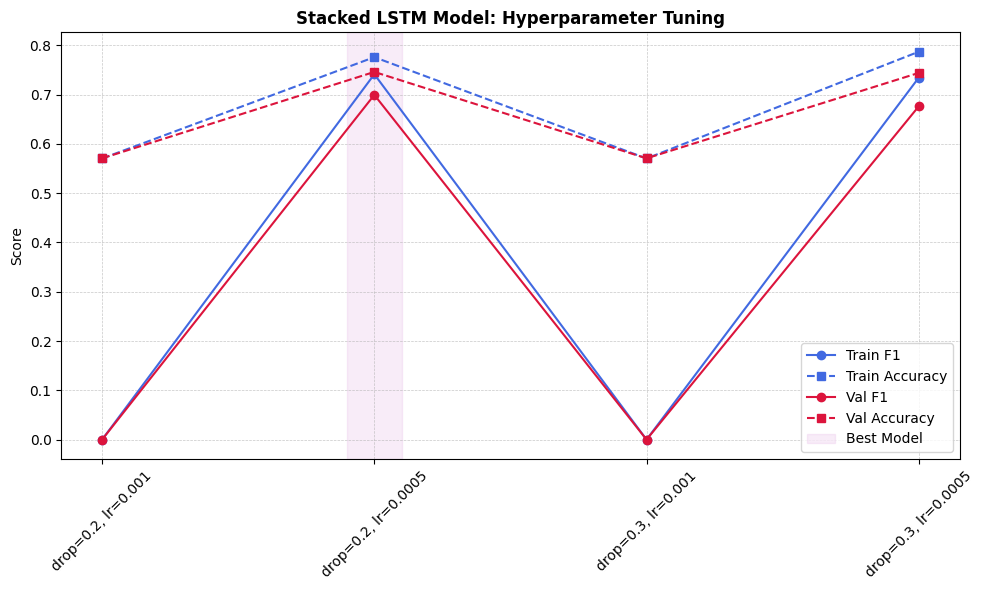

In [18]:
# ------------------------
# Plot Results
# ------------------------
lstm_summary_df = pd.DataFrame(lstm_summary)
lstm_summary_df["label"] = lstm_summary_df.apply(
    lambda row: f"drop={row['dropout_rate']}, lr={row['lr']}", axis=1
)

x = range(len(lstm_summary_df))
plt.figure(figsize=(10,6))

# Train metrics
plt.plot(x, lstm_summary_df["train_f1"], marker="o", linestyle="-", 
         color="RoyalBlue", label="Train F1")
plt.plot(x, lstm_summary_df["train_acc"], marker="s", linestyle="--", 
         color="RoyalBlue", label="Train Accuracy")

# Validation metrics
plt.plot(x, lstm_summary_df["val_f1"], marker="o", linestyle="-",
         color="Crimson", label="Val F1")
plt.plot(x, lstm_summary_df["val_acc"], marker="s", linestyle="--",
         color="Crimson", label="Val Accuracy")

# Highlight best model
best_idx = lstm_summary_df["val_f1"].idxmax()
plt.axvspan(
    best_idx - 0.1,
    best_idx + 0.1,
    color="Plum",
    alpha=0.2,
    label="Best Model"
)

# Labels & style
plt.xticks(x, lstm_summary_df["label"], rotation=45)
plt.title("Stacked LSTM Model: Hyperparameter Tuning", weight="bold")
plt.ylabel("Score")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

---
## Model 2: Hybrid Conv1D + LSTM (Tuning and Results)

Again, we tuned our hybrid Conv1D + LSTM model by checking the same parameter groups we used on the stacked LSTM model. Then we plotted our results as before.

We see similar results here. Like before, we found our highest F1 score when our dropout rate was set to
$0.2$
and our learning rate was set to 
${\color{HotPink}{\eta}}
    = {\color{HotPink}{0.0005}}$.

In [43]:
# -----------------------------
# Tuning and Metrics
# -----------------------------
hyperparams = [
    {"dropout_rate": 0.2, "lr": 0.001},
    {"dropout_rate": 0.2, "lr": 0.0005},
    {"dropout_rate": 0.3, "lr": 0.001},
    {"dropout_rate": 0.3, "lr": 0.0005},
]

best_val_f1 = 0
best_model_conv_lstm = None
conv_lstm_summary = []

def conv_lstm_predict(model, dataset, labeled=True):
    all_probs = []
    all_labels = []
    for batch in dataset:
        if labeled:
            Xb, yb = batch
            all_labels.append(yb.numpy())
        else:
            Xb = batch
        probs = model.predict(Xb, verbose=0)
        all_probs.append(probs)
    all_probs = np.concatenate(all_probs).flatten()
    if labeled:
        all_labels = np.concatenate(all_labels).flatten().astype(int)
        return all_probs, all_labels
    return all_probs

for params in hyperparams:
    display(HTML(f"<br><strong>Training model with params: {params}</strong><br>"))
    model = conv_lstm(dropout_rate=params["dropout_rate"], lr=params["lr"])

    history = model.fit(
        train_set,
        validation_data=val_set,
        epochs=10,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=3, restore_best_weights=True
            )]
    )

    # Predict train + val
    train_probs, train_labels = conv_lstm_predict(model, train_set, labeled=True)
    val_probs, val_labels = conv_lstm_predict(model, val_set, labeled=True)

    # Convert probabilities to binary predictions
    train_preds = (train_probs > 0.5).astype(int)
    val_preds = (val_probs > 0.5).astype(int)

    # Compute metrics
    train_f1 = f1_score(train_labels, train_preds)
    val_f1 = f1_score(val_labels, val_preds)
    train_acc = accuracy_score(train_labels, train_preds)
    val_acc = accuracy_score(val_labels, val_preds)
    print(f"\n    Train F1: {train_f1:.4f} | Train Acc: {train_acc:.4f}")
    print(f"    Val   F1: {val_f1:.4f} | Val   Acc: {val_acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(val_labels, val_preds)
    print("\nConfusion Matrix (Val):")
    print(cm)

    # Save metrics
    conv_lstm_summary.append({
        "dropout_rate": params["dropout_rate"],
        "lr": params["lr"],
        "train_f1": train_f1,
        "val_f1": val_f1,
        "train_acc": train_acc,
        "val_acc": val_acc
    })

    # Track best by F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_conv_lstm = model
        print("    Best model updated by val F1\n")

# Metrics summary table
conv_lstm_summary_df = pd.DataFrame(conv_lstm_summary)
display(HTML(f"<br><strong>Hyperparameter Summary</strong>"))
display(conv_lstm_summary_df)

# Best model metrics
best_row = conv_lstm_summary_df.loc[conv_lstm_summary_df["val_f1"].idxmax()]
display(HTML(f"<br><strong>Best Hybrid Conv1D + LSTM Model</strong>"))
display(best_row)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.6111 - f1: 0.2661 - loss: 0.6547 - precision: 0.6435 - recall: 0.1829 - val_accuracy: 0.7879 - val_f1: 0.7283 - val_loss: 0.4670 - val_precision: 0.8093 - val_recall: 0.6621
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8348 - f1: 0.7946 - loss: 0.3903 - precision: 0.8632 - recall: 0.7365 - val_accuracy: 0.7919 - val_f1: 0.7365 - val_loss: 0.5078 - val_precision: 0.8069 - val_recall: 0.6774
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9180 - f1: 0.9009 - loss: 0.2322 - precision: 0.9477 - recall: 0.8587 - val_accuracy: 0.7892 - val_f1: 0.7300 - val_loss: 0.5765 - val_precision: 0.8112 - val_recall: 0.6636
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9536 - f1: 0.9454 - loss: 0.1467 - precision: 0.9668 - recall: 0.9250 - val_accuracy: 0.7807 - val_f1: 0.7226 - val_loss: 0.6929 - val_precision: 0.7909 - val_recall: 0.6651

    Train F1: 0.8406 | Train Acc: 

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.5797 - f1: 0.0809 - loss: 0.6884 - precision: 0.2852 - recall: 0.0495 - val_accuracy: 0.7853 - val_f1: 0.7317 - val_loss: 0.4875 - val_precision: 0.7894 - val_recall: 0.6820
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8202 - f1: 0.7756 - loss: 0.4291 - precision: 0.8469 - recall: 0.7159 - val_accuracy: 0.7951 - val_f1: 0.7459 - val_loss: 0.4900 - val_precision: 0.7979 - val_recall: 0.7003
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9092 - f1: 0.8903 - loss: 0.2592 - precision: 0.9357 - recall: 0.8494 - val_accuracy: 0.7879 - val_f1: 0.7363 - val_loss: 0.5316 - val_precision: 0.7898 - val_recall: 0.6896
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9464 - f1: 0.9366 - loss: 0.1705 - precision: 0.9628 - recall: 0.9119 - val_accuracy: 0.7807 - val_f1: 0.7169 - val_loss: 0.6168 - val_precision: 0.8042 - val_recall: 0.6468

    Train F1: 0.8095 | Train Acc: 

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.6019 - f1: 0.2199 - loss: 0.6662 - precision: 0.6250 - recall: 0.1463 - val_accuracy: 0.7991 - val_f1: 0.7407 - val_loss: 0.4658 - val_precision: 0.8308 - val_recall: 0.6682
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8300 - f1: 0.7894 - loss: 0.4028 - precision: 0.8538 - recall: 0.7344 - val_accuracy: 0.8024 - val_f1: 0.7451 - val_loss: 0.5006 - val_precision: 0.8349 - val_recall: 0.6728
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.9112 - f1: 0.8925 - loss: 0.2475 - precision: 0.9407 - recall: 0.8493 - val_accuracy: 0.7919 - val_f1: 0.7356 - val_loss: 0.5724 - val_precision: 0.8092 - val_recall: 0.6743
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.9437 - f1: 0.9334 - loss: 0.1592 - precision: 0.9599 - recall: 0.9085 - val_accuracy: 0.7814 - val_f1: 0.7321 - val_loss: 0.6493 - val_precision: 0.7725 - val_recall: 0.6957

    Train F1: 0.8312 | Train Acc

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.5743 - f1: 0.0944 - loss: 0.6929 - precision: 0.5395 - recall: 0.0570 - val_accuracy: 0.7577 - val_f1: 0.7305 - val_loss: 0.5202 - val_precision: 0.6993 - val_recall: 0.7645
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8018 - f1: 0.7525 - loss: 0.4559 - precision: 0.8235 - recall: 0.6934 - val_accuracy: 0.7978 - val_f1: 0.7504 - val_loss: 0.4912 - val_precision: 0.7983 - val_recall: 0.7080
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9051 - f1: 0.8858 - loss: 0.2687 - precision: 0.9275 - recall: 0.8477 - val_accuracy: 0.7905 - val_f1: 0.7400 - val_loss: 0.5432 - val_precision: 0.7923 - val_recall: 0.6942
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9424 - f1: 0.9315 - loss: 0.1808 - precision: 0.9636 - recall: 0.9015 - val_accuracy: 0.7925 - val_f1: 0.7345 - val_loss: 0.6066 - val_precision: 0.8153 - val_recall: 0.6682
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━

,dropout_rate,lr,train_f1,val_f1,train_acc,val_acc
0,0.2,0.0010,0.840634,0.728343,0.874548,0.787919
1,0.2,0.0005,0.809466,0.731747,0.845320,0.785292
2,0.3,0.0010,0.831234,0.740678,0.867980,0.799081
3,0.3,0.0005,0.901820,0.750405,0.919376,0.797768


dropout_rate    0.300000
lr              0.000500
train_f1        0.901820
val_f1          0.750405
train_acc       0.919376
val_acc         0.797768
Name: 3, dtype: float64

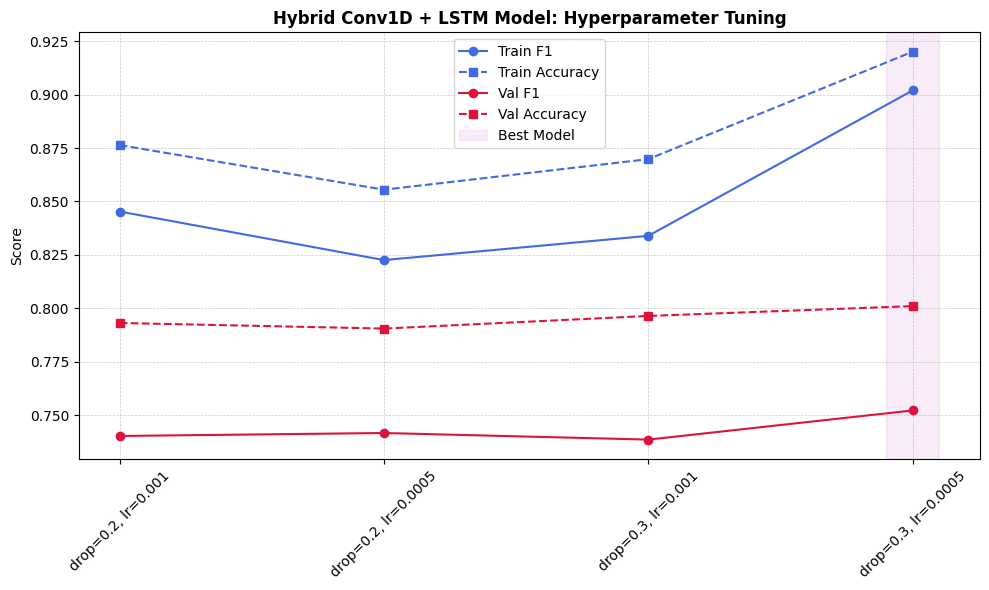

In [40]:
# ------------------------
# Plot Results
# ------------------------
conv_lstm_summary_df = pd.DataFrame(conv_lstm_summary_df)
conv_lstm_summary_df["label"] = conv_lstm_summary_df.apply(
    lambda row: f"drop={row['dropout_rate']}, lr={row['lr']}", axis=1
)

x = range(len(conv_lstm_summary_df))
plt.figure(figsize=(10,6))

# Train metrics
plt.plot(x, conv_lstm_summary_df["train_f1"], marker="o", linestyle="-", 
         color="RoyalBlue", label="Train F1")
plt.plot(x, conv_lstm_summary_df["train_acc"], marker="s", linestyle="--", 
         color="RoyalBlue", label="Train Accuracy")

# Validation metrics
plt.plot(x, conv_lstm_summary_df["val_f1"], marker="o", linestyle="-",
         color="Crimson", label="Val F1")
plt.plot(x, conv_lstm_summary_df["val_acc"], marker="s", linestyle="--",
         color="Crimson", label="Val Accuracy")

# Highlight best model
best_idx = conv_lstm_summary_df["val_f1"].idxmax()
plt.axvspan(
    best_idx - 0.1,
    best_idx + 0.1,
    color="Plum",
    alpha=0.2,
    label="Best Model"
)

# Labels & style
plt.xticks(x, conv_lstm_summary_df["label"], rotation=45)
plt.title("Hybrid Conv1D + LSTM Model: Hyperparameter Tuning", weight="bold")
plt.ylabel("Score")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

<br>

---
---
# **5.  Conclusion**

---
## Final Results

The final F1 scores and accuracy scores for all our models are shown in the table below. The highest Val F1 scores for each model are marked in Orchid.

| **Stacked LSTM**   | **Params**                       | **Train F1**  | **Val F1** | **Train Acc** | **Val Acc**   |
|:--------------:|:----------------------:|:-------------:|:-----------------:|:-----------:|:---------------:|
|                    | `drop = 0.2`, <br> `lr = 0.001`  | $0.000000$   | $0.000000$ | $0.570279$ | $0.570584$ |
|                    | `drop = 0.2`, <br> `lr = 0.0005` | $0.74113$   | ${\color{Orchid}{0.699301}}$ | $0.775862$ | $0.745896$ |
|                    | `drop = 0.3`, <br> `lr = 0.001`  | $0.000000$   | $0.000000$ | $0.570279$ | $0.570584$ |
|                    | `drop = 0.3`, <br> `lr = 0.0005` | $0.734234$   | $0.676080$ | $0.786864$ | $0.743926$ |

<br>

| **Conv1D + LSTM** | **Params**                       | **Train F1** | **Val F1** | **Train Acc** | **Val Acc**   |
|:---------------:|:----------------------:|:-------------:|:-----------------:|:-----------:|:-----------------:|
|                   | `drop = 0.2`, <br> `lr = 0.001`  | $0.845285$   | $0.740313$ | $0.876355$    | $0.793171$ |
|                   | `drop = 0.2`, <br> `lr = 0.0005` |  $0.822581$   | $0.741700$ | $0.855501$    | $0.790545$ |
|                   | `drop = 0.3`, <br> `lr = 0.001`  | $0.833927$   | $0.738617$ | $0.869787$    | $0.796454$ |
|                   | `drop = 0.3`, <br> `lr = 0.0005` | $0.901913$   | ${\color{Orchid}{0.0.752249}}$ | $0.920033$    | $0.0.801051$ |

Our best performing model was the Hybrid Conv1D + LSTM model with the hyperparameters set to `dropout_rate=0.3, lr=0.0005`. Below, we run this model on our test set and generate a csv with our submission values.

In [44]:
# -----------------------------
# Best Hybrid Conv1D + LSTM on test set
# -----------------------------
X_test_seq = tokenizer.texts_to_sequences(test_v3["clean_text_lemma"])
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

test_probs = best_model_conv_lstm.predict(X_test_pad, verbose=1)
test_preds = (test_probs > 0.5).astype(int).flatten()

submission = pd.DataFrame({
    "id": test_v3["id"],
    "target": test_preds
})
submission.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


---
## Discussion

The better performance seen in the Hybrid Conv1D + LSTM model shows how adding these convolutional layers to look through the n-grams allowed the the model to look at local features before looking only through global features in general. Additionally, the bidirectionality of the first convolutional layer allowed this local feature examination to happen backwards and forwards on a tweet, so the model was able to get as granular as possible. That said, our model wasn't very large, so increasing the drop rate to
$0.3$
prevented overfitting and contributed to increased performance. The lowered learning rate of
${\color{HotPink}{\eta}}
    = {\color{HotPink}{0.0005}}$
allowed the model to reach convergence faster than we say with the larger learning rate.

For future improvements, I would add more 1D convolutional layers.